# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import missingno as msno
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
df= pd.read_excel('new_data_set.xlsx')

columns_to_check= ['facilityid', 'age', 'sex', 'time_erst_to_diag', 'mgfaklassifikation_schlimmste_historisch', 'dekrement_testergebnis', 'ee_autoimmunerkrankungen_rbzu', 
                   'ee_thymektomie_gr', 'kortison_aktuell', 'azathioprin_aktuell', 'mycophenolatmofetil_aktuell', 'methotrexatfolsauure_aktuell','rituximab_aktuell',
                   'scoreqmg_neu', 'chronicfatigue_neu', 'scoreqol_neu', 'scoreadl_neu', 'aktueller_mgfa_score', 'seronegative']

df_original= df[columns_to_check]
df_original.head()

,facilityid,age,sex,time_erst_to_diag,mgfaklassifikation_schlimmste_historisch,dekrement_testergebnis,ee_autoimmunerkrankungen_rbzu,ee_thymektomie_gr,kortison_aktuell,azathioprin_aktuell,mycophenolatmofetil_aktuell,methotrexatfolsauure_aktuell,rituximab_aktuell,scoreqmg_neu,chronicfatigue_neu,scoreqol_neu,scoreadl_neu,aktueller_mgfa_score,seronegative
0,2019009,34.961111,0,0.166667,8.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,NaN,NaN,2.0,3.0,0.0
1,2019006,59.711111,1,3.166667,2.0,1.0,NaN,0.0,0.0,0.0,1.0,0.0,0,1.0,NaN,NaN,NaN,2.0,0.0
2,2019010,83.344444,1,0.250000,5.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,5.0,12.0,7.0,3.0,2.0,0.0
3,2019019,56.505556,1,0.083333,2.0,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0,4.0,8.0,NaN,NaN,2.0,0.0
4,2019004,39.986111,0,0.000000,5.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,10.0,1.0,3.0,0.0


# Handling Missing Values: MICE Imputation (Decision Tree Regressor)

In [3]:
# Define the columns
continuous_columns = ['age', 'time_erst_to_diag', 'scoreqmg_neu', 'chronicfatigue_neu', 'scoreqol_neu', 'scoreadl_neu']

categorical_columns = ['sex', 'mgfaklassifikation_schlimmste_historisch', 'dekrement_testergebnis', 'ee_autoimmunerkrankungen_rbzu',
                       'ee_thymektomie_gr', 'kortison_aktuell', 'azathioprin_aktuell', 'mycophenolatmofetil_aktuell', 
                       'methotrexatfolsauure_aktuell', 'aktueller_mgfa_score', 'seronegative']

# Custom function for rounding categorical variables
def round_categorical(imputed_data, categorical_columns):
    imputed_data[categorical_columns] = imputed_data[categorical_columns].round().astype(int)
    return imputed_data

# Custom function to enforce non-negative values on continuous columns
def enforce_non_negative(df, continuous_columns):
    df[continuous_columns] = df[continuous_columns].applymap(lambda x: max(x, 0))
    return df

In [4]:
# Tune DecisionTreeRegressor
dt_estimator = DecisionTreeRegressor(max_depth=20,        
                                     min_samples_split=5, 
                                     min_samples_leaf=3,  
                                     random_state=0)

# Initialize the MICE imputer with tuned DecisionTreeRegressor
mice_imputer = IterativeImputer(estimator=dt_estimator, 
                                max_iter=30,  
                                random_state=0, 
                                tol=1e-4,  
                                n_nearest_features=10,  
                                initial_strategy='median')

In [5]:
# Fit and transform the dataset (df_original)
df_imputed = mice_imputer.fit_transform(df_original)

# Convert the imputed result back to a DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=df_original.columns)

# Apply rounding to categorical variables
df_imputed = round_categorical(df_imputed, categorical_columns)

# Enforce non-negative values on continuous columns post-imputation
df_imputed = enforce_non_negative(df_imputed, continuous_columns)

# Output the imputed dataset
df_imputed_dataset = df_imputed

df_imputed_dataset.head()

,facilityid,age,sex,time_erst_to_diag,mgfaklassifikation_schlimmste_historisch,dekrement_testergebnis,ee_autoimmunerkrankungen_rbzu,ee_thymektomie_gr,kortison_aktuell,azathioprin_aktuell,mycophenolatmofetil_aktuell,methotrexatfolsauure_aktuell,rituximab_aktuell,scoreqmg_neu,chronicfatigue_neu,scoreqol_neu,scoreadl_neu,aktueller_mgfa_score,seronegative
0,2019009.0,34.961111,0,0.166667,8,1,0,1,0,0,0,0,0.0,0.0,13.6,12.250000,2.00,3,0
1,2019006.0,59.711111,1,3.166667,2,1,0,0,0,0,1,0,0.0,1.0,13.6,11.333333,6.00,2,0
2,2019010.0,83.344444,1,0.250000,5,0,1,0,0,0,1,0,0.0,5.0,12.0,7.000000,3.00,2,0
3,2019019.0,56.505556,1,0.083333,2,0,0,0,1,1,0,0,0.0,4.0,8.0,15.600000,5.25,2,0
4,2019004.0,39.986111,0,0.000000,5,1,1,0,0,1,0,0,0.0,4.6,10.0,10.000000,1.00,3,0


In [6]:
# Calculate frequencies and distributions for original dataset

summary_stats= df_imputed_dataset.describe(include= 'all').T
summary_stats_rounded= summary_stats.round(2)
summary_stats_rounded

,count,mean,std,min,25%,50%,75%,max
facilityid,2233.0,2019005.64,5.09,2019001.0,2019001.00,2019004.00,2019008.00,2019021.00
age,2233.0,60.06,17.72,0.0,48.89,62.53,73.73,101.00
sex,2233.0,0.45,0.50,0.0,0.00,0.00,1.00,1.00
time_erst_to_diag,2233.0,1.50,3.73,0.0,0.08,0.25,1.00,46.83
mgfaklassifikation_schlimmste_historisch,2233.0,2.97,1.70,0.0,2.00,3.00,4.00,8.00
dekrement_testergebnis,2233.0,0.55,0.50,0.0,0.00,1.00,1.00,1.00
ee_autoimmunerkrankungen_rbzu,2233.0,0.26,0.44,0.0,0.00,0.00,1.00,1.00
ee_thymektomie_gr,2233.0,0.39,0.49,0.0,0.00,0.00,1.00,1.00
kortison_aktuell,2233.0,0.57,0.49,0.0,0.00,1.00,1.00,1.00
azathioprin_aktuell,2233.0,0.45,0.50,0.0,0.00,0.00,1.00,1.00


# Plotting the distributions of continuous variables for both original and imputed data

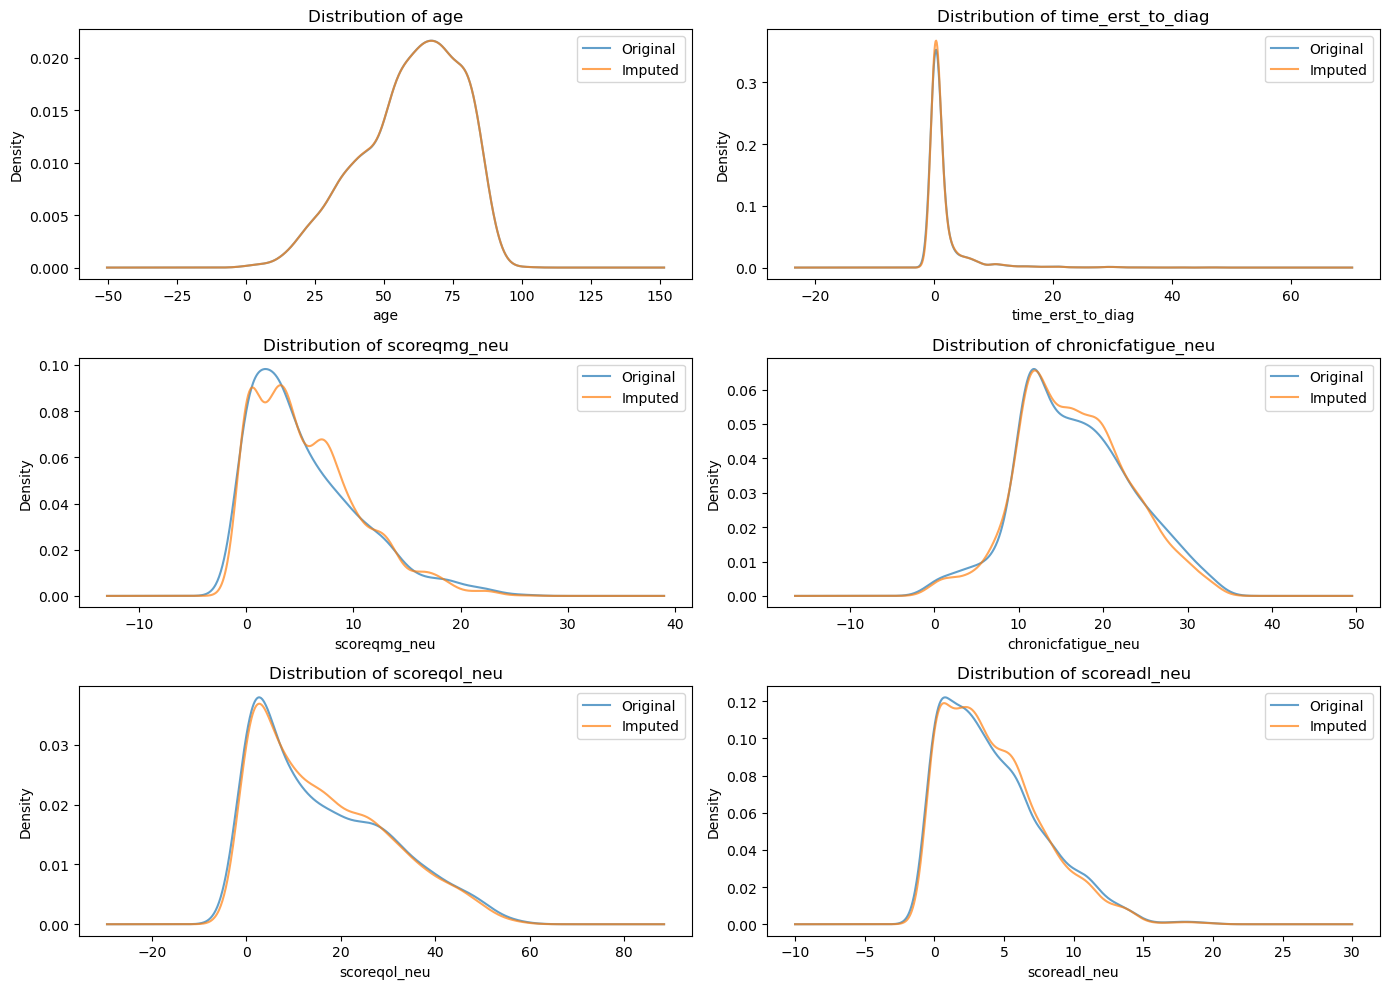

In [7]:
continuous_columns = ['age', 'time_erst_to_diag', 'scoreqmg_neu', 'chronicfatigue_neu', 'scoreqol_neu', 'scoreadl_neu']

plt.figure(figsize=(14, 10))

for i, col in enumerate(continuous_columns):
    plt.subplot(3, 2, i+1)
    df_original[col].plot(kind='density', label='Original', alpha=0.7)
    df_imputed_dataset[col].plot(kind='density', label='Imputed', alpha=0.7)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.legend()

plt.tight_layout()
plt.show()

# Plotting the distributions of categorical variables for both original and imputed data

In [8]:
categorical_columns_1= ['mgfaklassifikation_schlimmste_historisch', 'dekrement_testergebnis', 'ee_autoimmunerkrankungen_rbzu', 'ee_thymektomie_gr', 'kortison_aktuell']
categorical_columns_2= ['azathioprin_aktuell', 'mycophenolatmofetil_aktuell', 'methotrexatfolsauure_aktuell', 'aktueller_mgfa_score', 'seronegative']

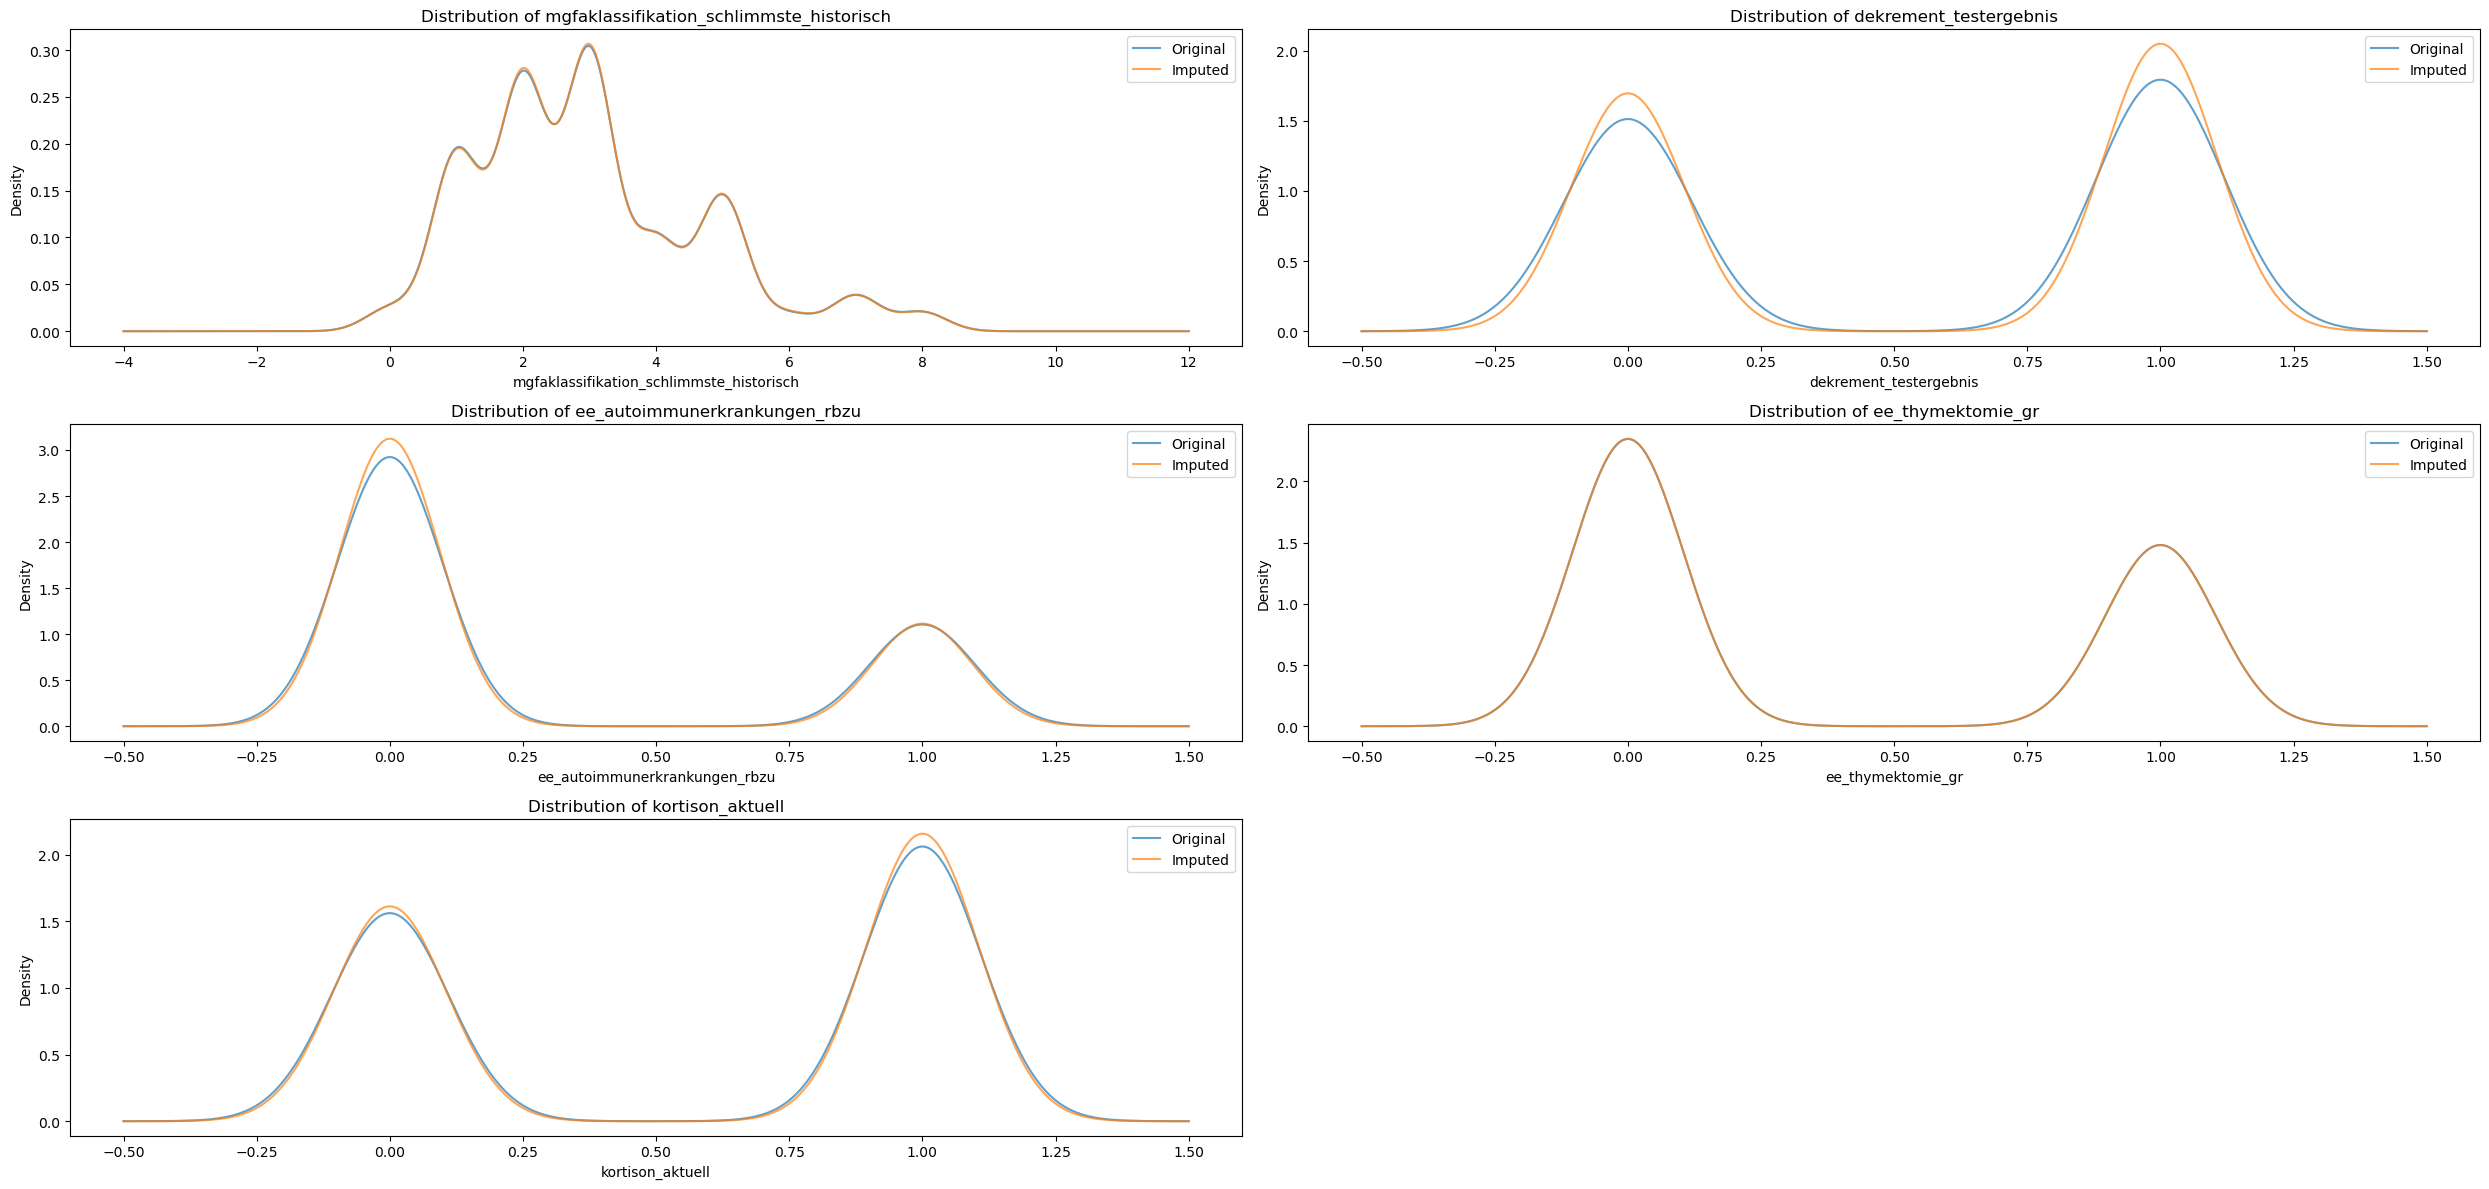

In [9]:
plt.figure(figsize=(25, 12))

for i, col in enumerate(categorical_columns_1):
    plt.subplot(3, 2, i+1)
    df_original[col].plot(kind='density', label='Original', alpha=0.7)
    df_imputed_dataset[col].plot(kind='density', label='Imputed', alpha=0.7)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.legend()

plt.tight_layout()
plt.show()

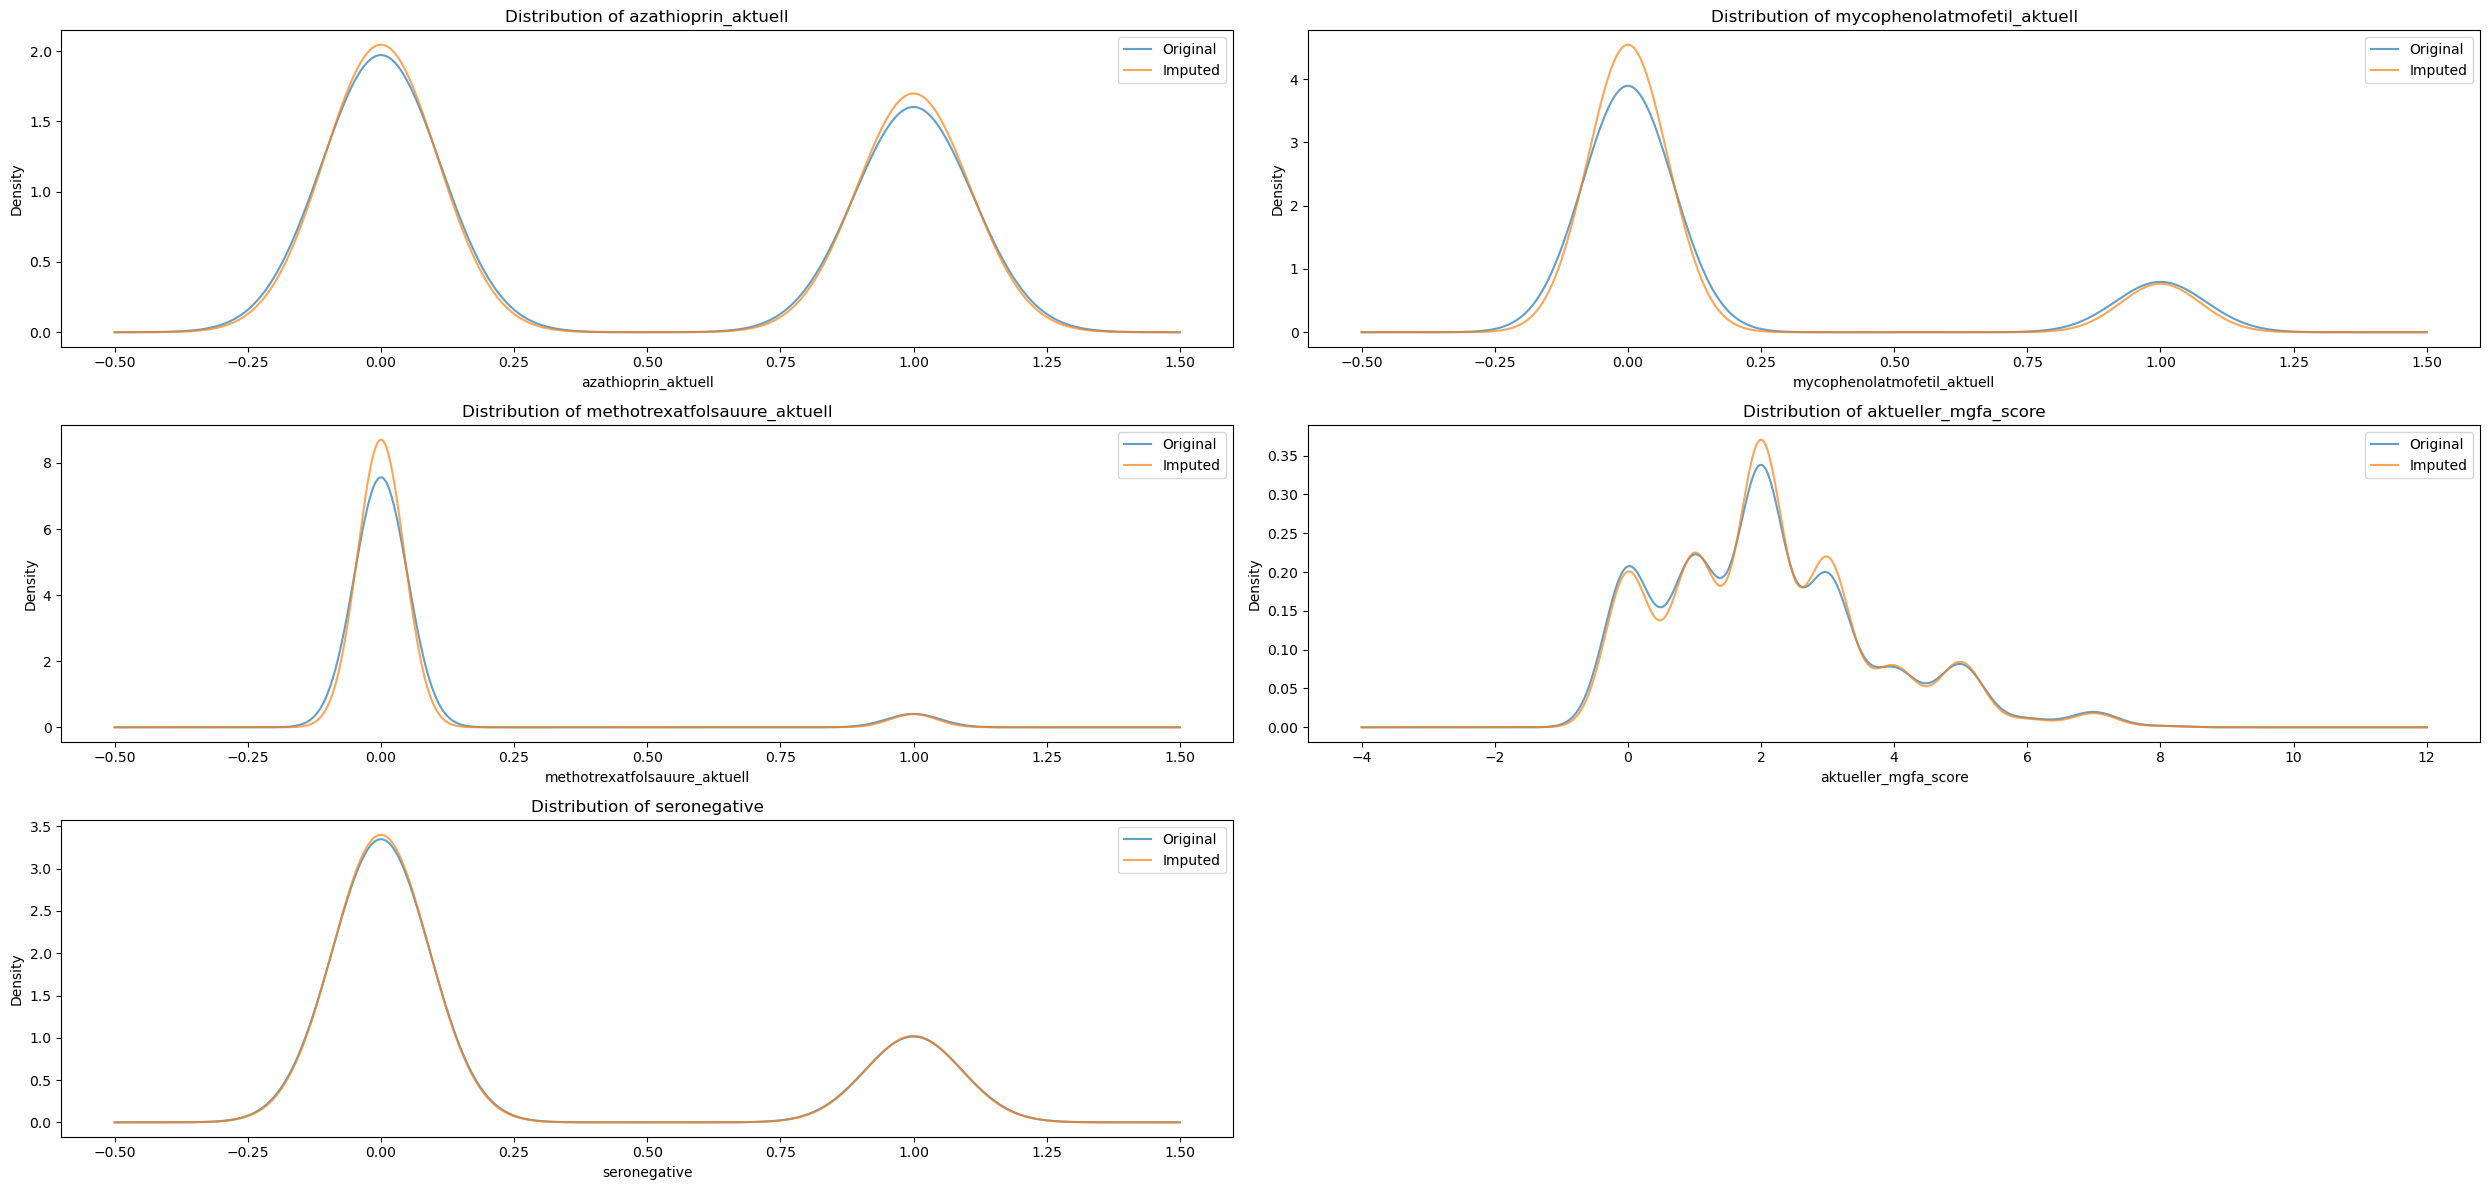

In [10]:
plt.figure(figsize=(25, 12))

for i, col in enumerate(categorical_columns_2):
    plt.subplot(3, 2, i+1)
    df_original[col].plot(kind='density', label='Original', alpha=0.7)
    df_imputed_dataset[col].plot(kind='density', label='Imputed', alpha=0.7)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.legend()

plt.tight_layout()
plt.show()

# Plotting for score columns

In [11]:
# Score Columns
score_columns = ['scoreqmg_neu', 'chronicfatigue_neu', 'scoreqol_neu', 'scoreadl_neu', 'aktueller_mgfa_score']

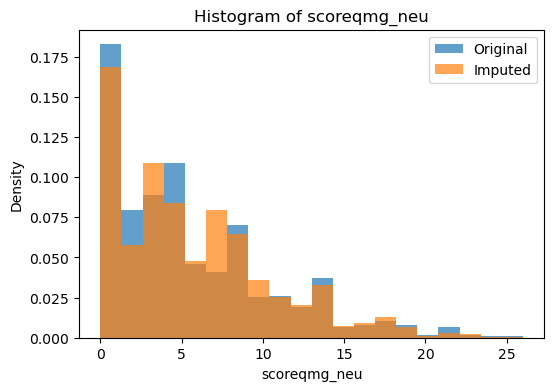

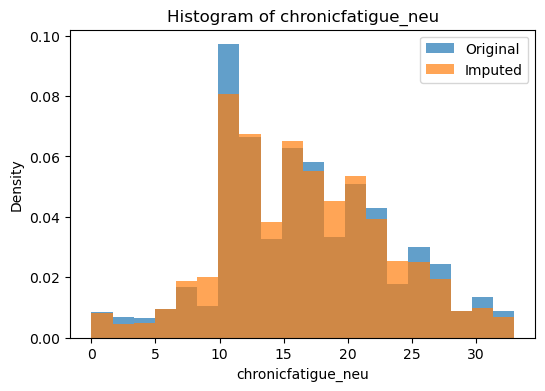

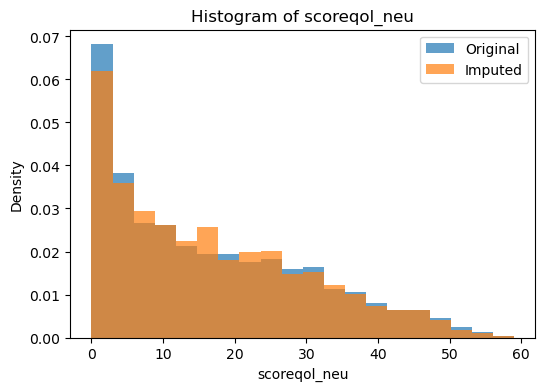

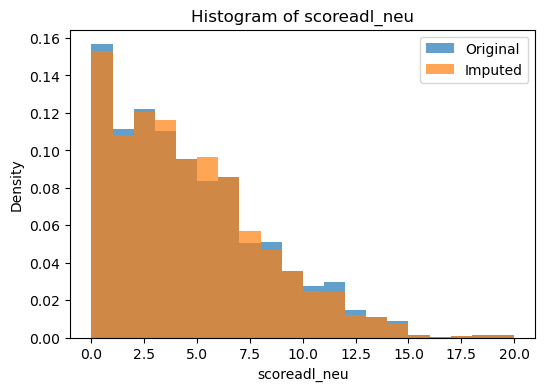

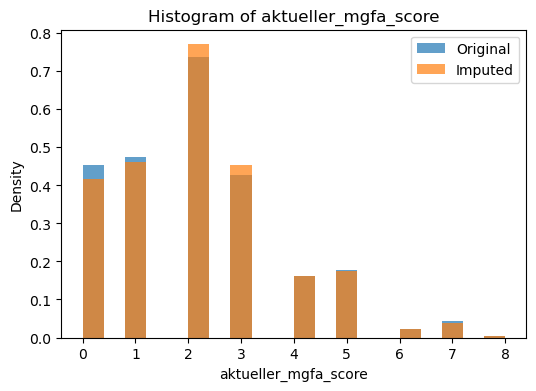

In [12]:
# Plotting histograms for each score column separately
for col in score_columns:
    plt.figure(figsize=(6, 4))
    df_original[col].plot(kind='hist', bins=20, alpha=0.7, label='Original', density=True)
    df_imputed_dataset[col].plot(kind='hist', bins=20, alpha=0.7, label='Imputed', density=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Box Plot between score variables and 'seronegative' for both Original and Imputed data

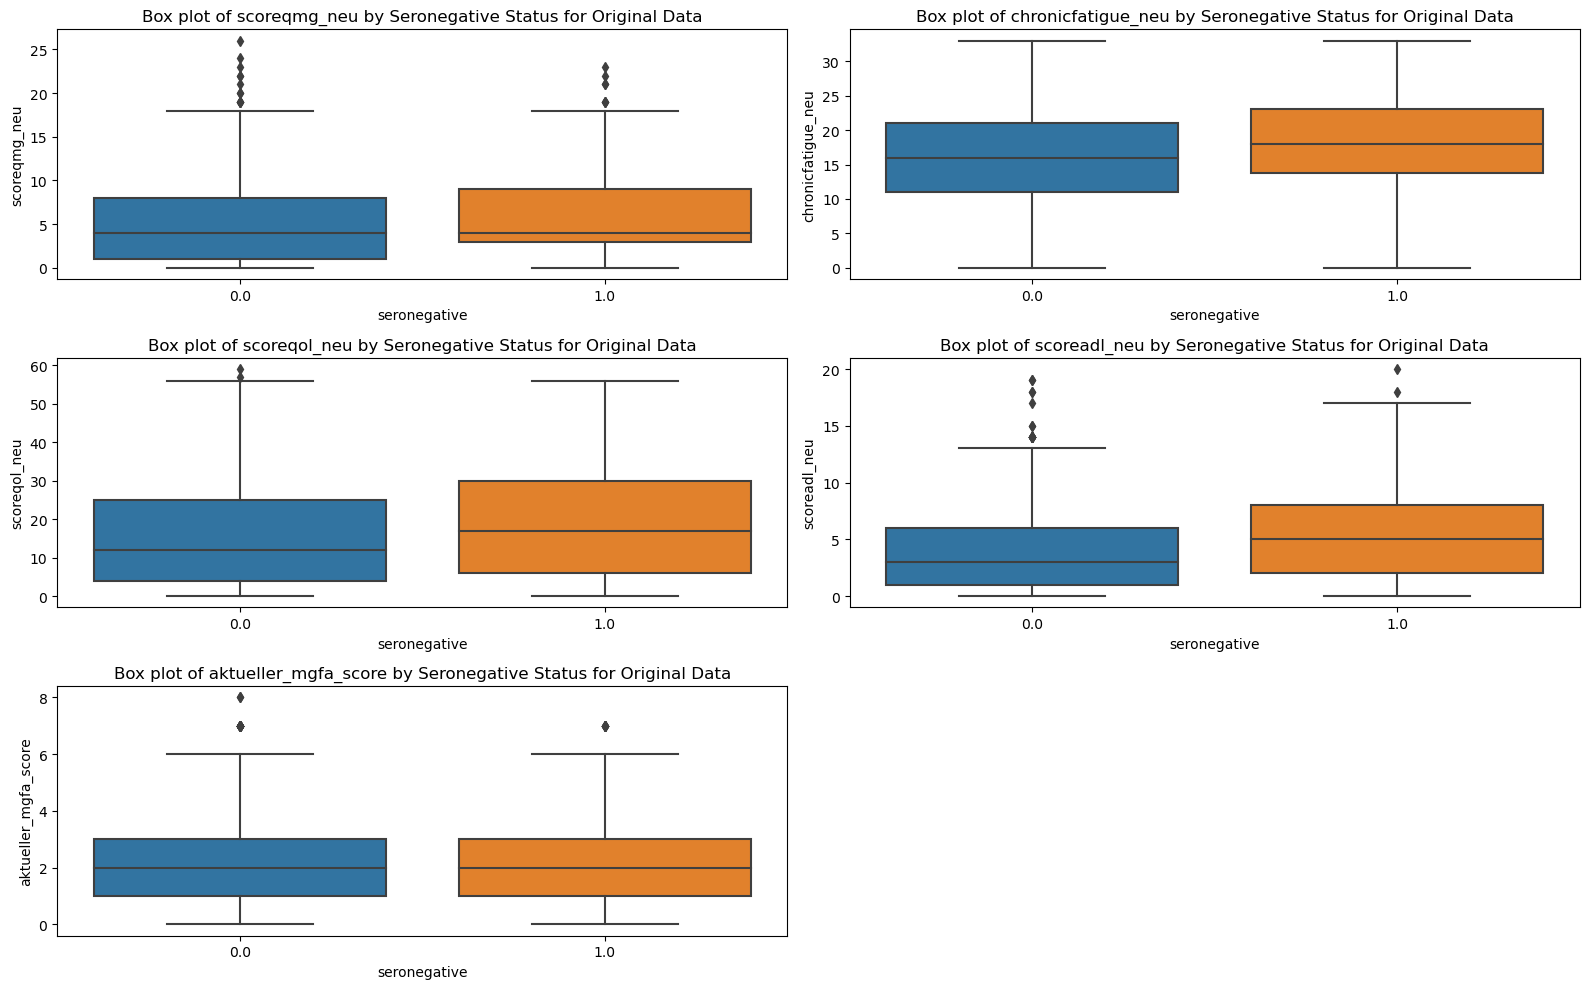

In [13]:
# Plotting boxplots for original data
plt.figure(figsize=(16, 10))

for i, col in enumerate(score_columns):
    plt.subplot(3, 2, i+1)  
    sns.boxplot(x='seronegative', y=col, data=df_original)
    plt.title(f'Box plot of {col} by Seronegative Status for Original Data')

plt.tight_layout()
plt.show()

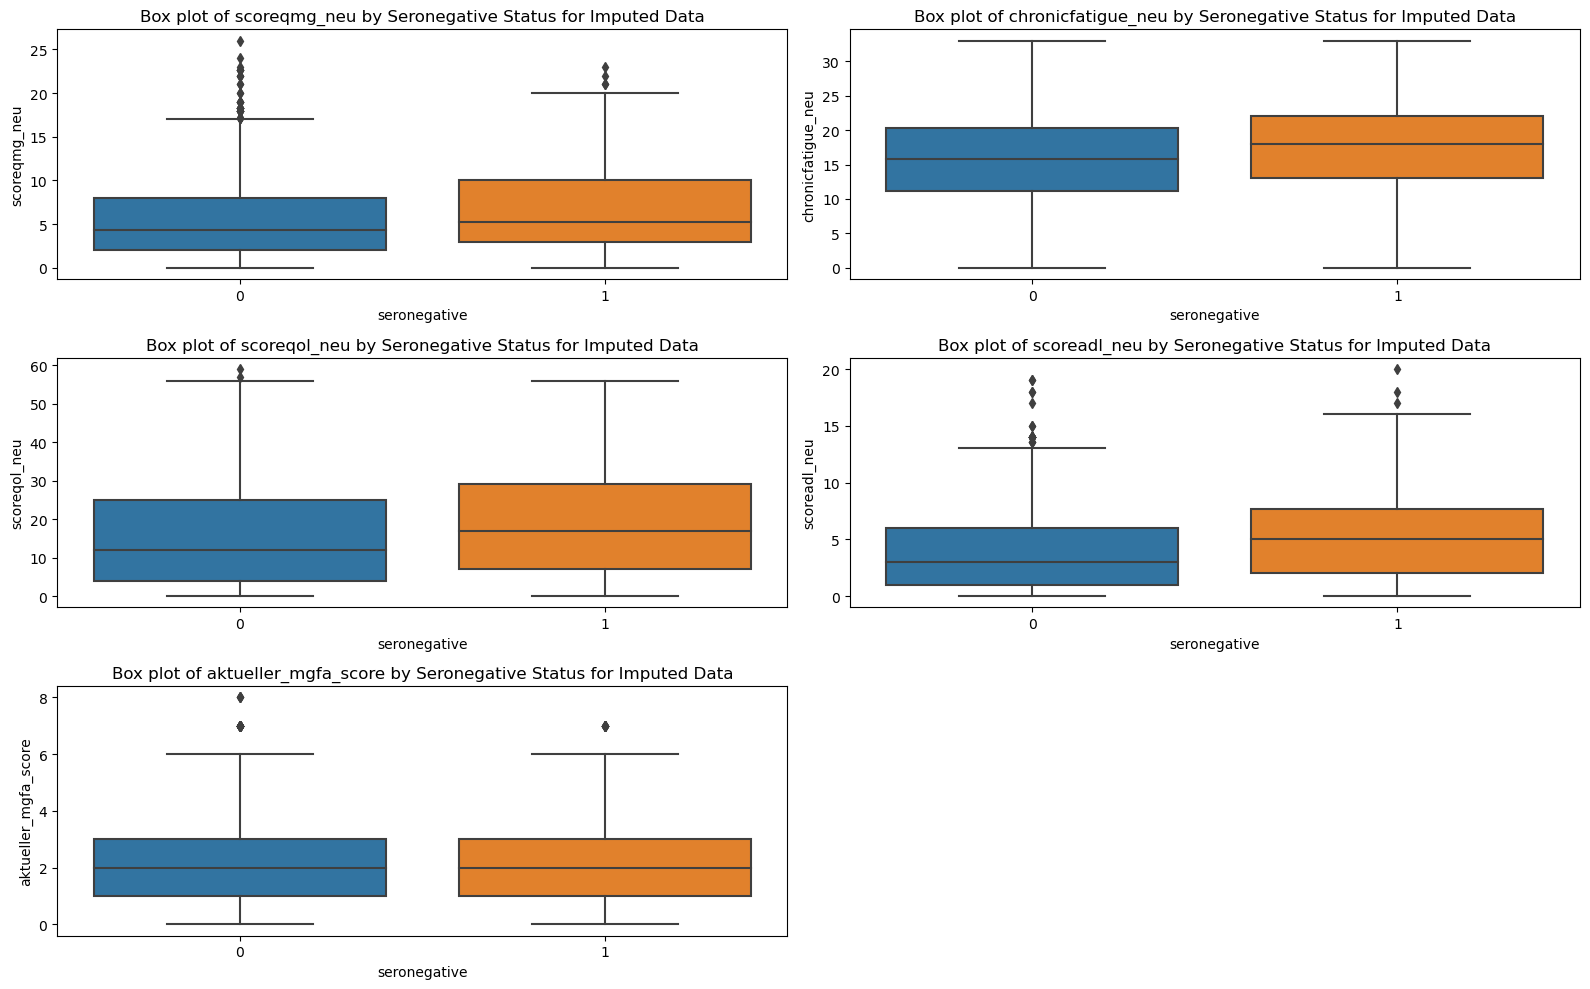

In [14]:
# Plotting boxplots for imputed data
plt.figure(figsize=(16, 10))

for i, col in enumerate(score_columns):
    plt.subplot(3, 2, i+1)  
    sns.boxplot(x='seronegative', y=col, data=df_imputed_dataset)
    plt.title(f'Box plot of {col} by Seronegative Status for Imputed Data')

plt.tight_layout()
plt.show()

# Linear Regression for Original Data

<Axes: >

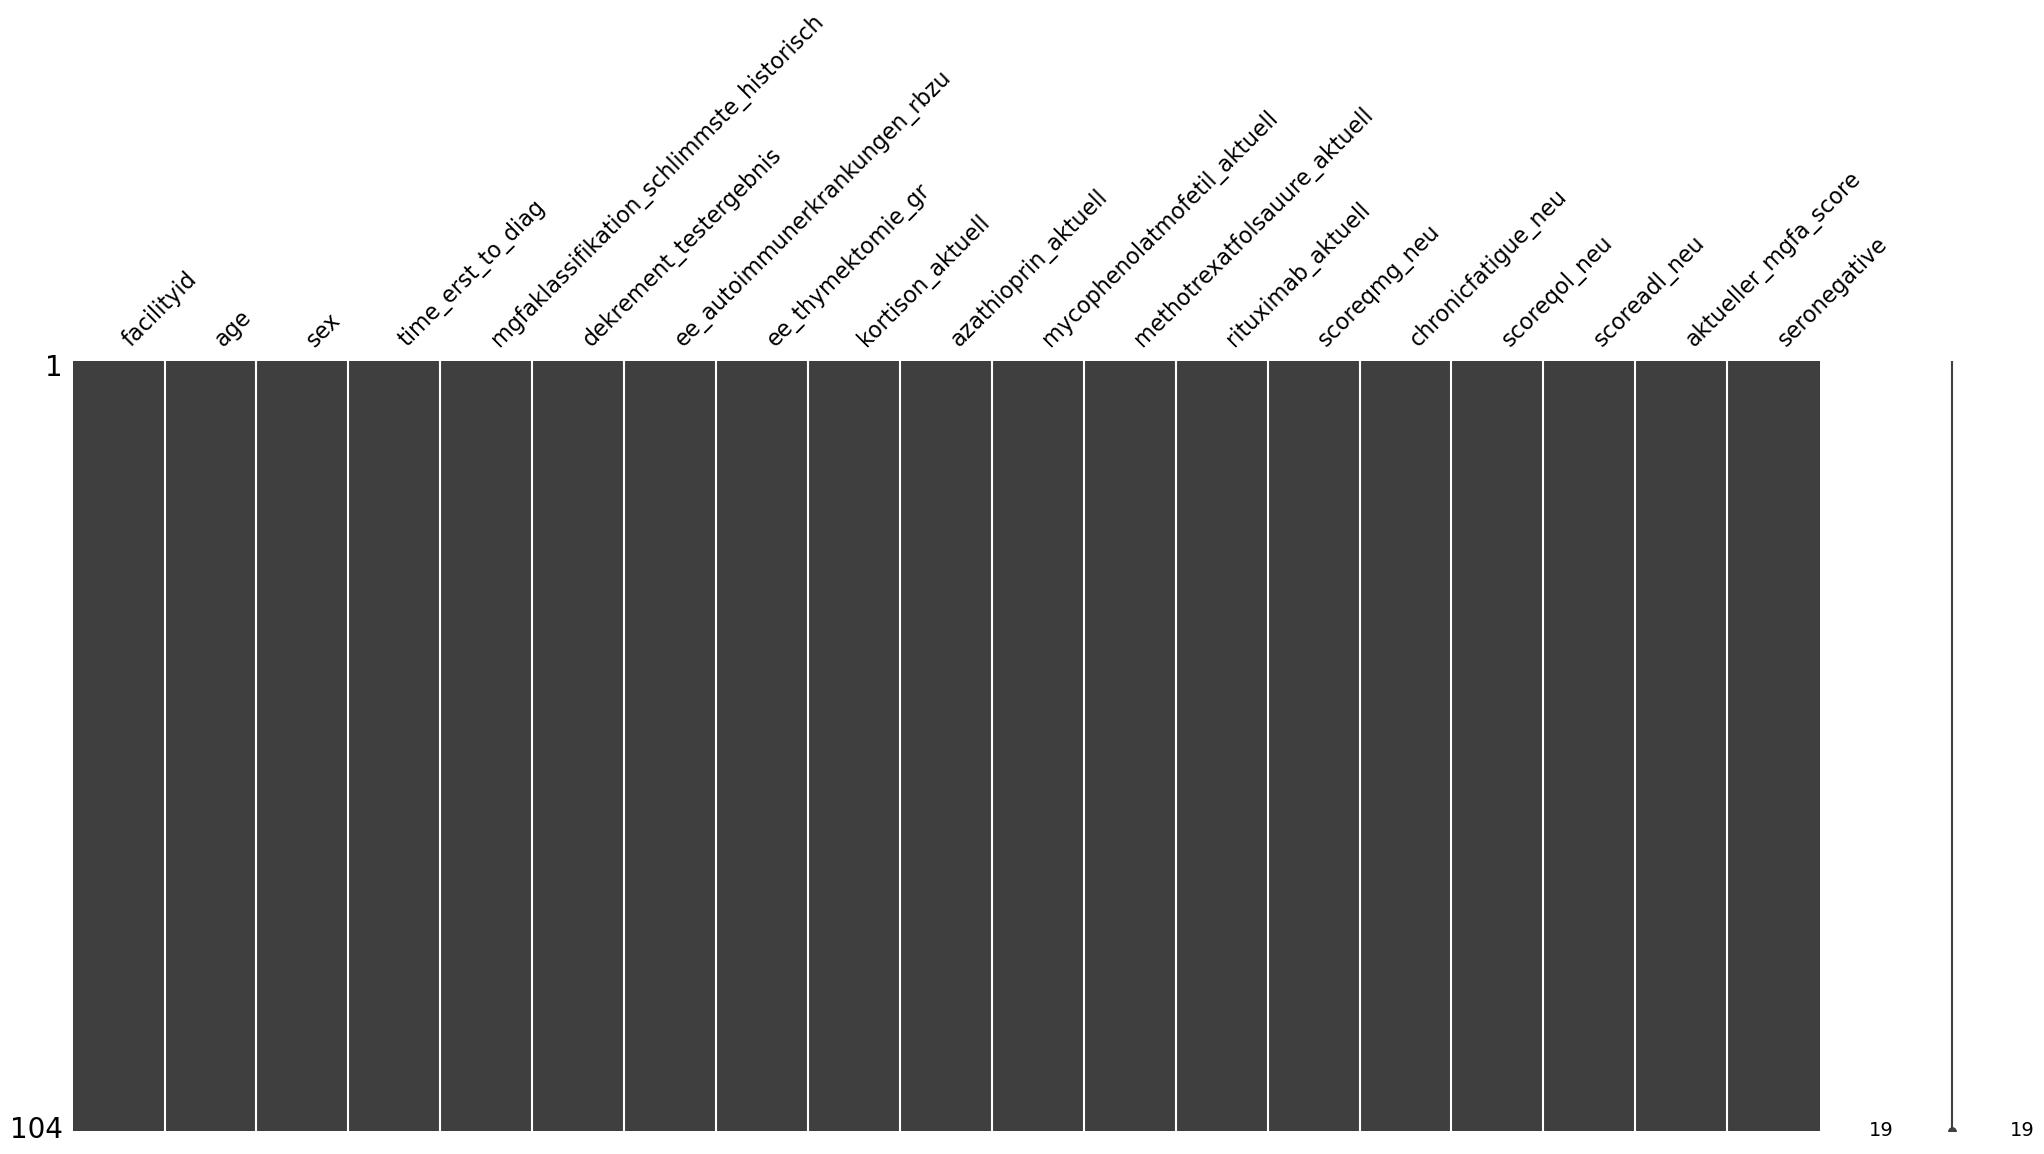

In [15]:
df_cleaned= df_original.dropna()
msno.matrix(df_cleaned)

In [16]:
# Define the feature and targets
feature = ['facilityid', 'age', 'sex', 'time_erst_to_diag', 'mgfaklassifikation_schlimmste_historisch', 
            'dekrement_testergebnis', 'ee_autoimmunerkrankungen_rbzu', 'ee_thymektomie_gr', 
            'kortison_aktuell', 'azathioprin_aktuell', 'mycophenolatmofetil_aktuell', 
            'methotrexatfolsauure_aktuell', 'rituximab_aktuell', 'seronegative']

# List of targets (outcome variables)
targets = ['scoreqmg_neu', 'chronicfatigue_neu', 'scoreqol_neu', 'scoreadl_neu', 'aktueller_mgfa_score']

# Store coefficients in a list for visualization
coefficients = []

# Loop through each target and fit a separate regression model
for target in targets:
    # Create and fit the regression model
    model = LinearRegression()
    
    # Reshape the feature
    X = df_cleaned[feature]
    y = df_cleaned[target]
    
    # Fit the model
    model.fit(X, y)
    
    # Get the coefficient of the model
    coefficient = model.coef_[0]
    
    # Append the coefficient to the list
    coefficients.append(coefficient)

# Create a DataFrame for the coefficients
coefficients_df = pd.DataFrame({
    'Target': targets,
    'Coefficient': coefficients
})

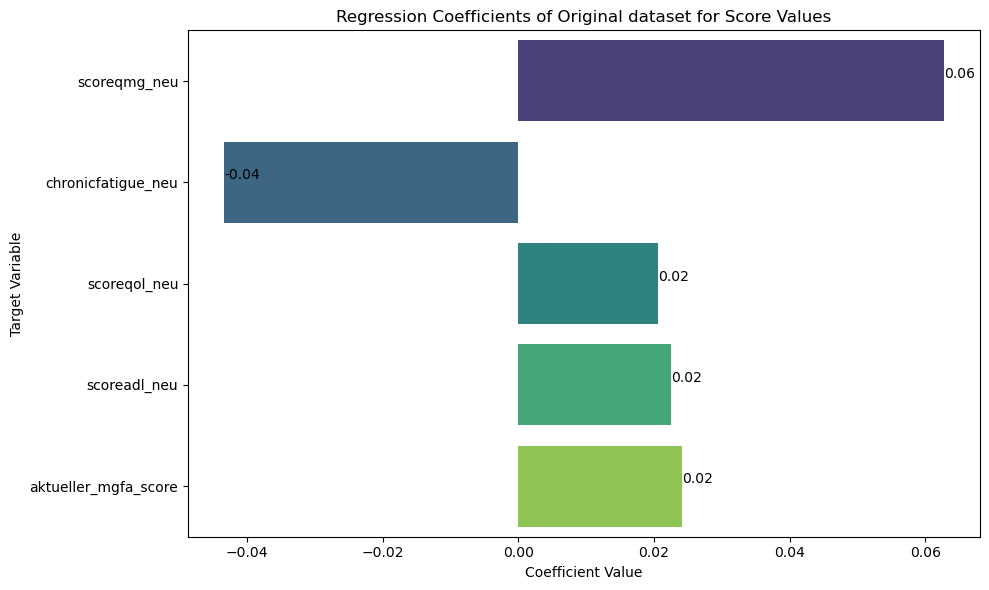

In [17]:
# Plotting the coefficients as a horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Target', data=coefficients_df, orient='h', palette='viridis')

# Add labels and title
plt.title('Regression Coefficients of Original dataset for Score Values')
plt.xlabel('Coefficient Value')
plt.ylabel('Target Variable')

# Add numerical values on the bars
for index, value in enumerate(coefficients_df['Coefficient']):
    plt.text(value, index, f'{value:.2f}', va='bottom', color='black')

# Display the plot
plt.tight_layout()
plt.show()

# Linear Regression for Imputed Data

In [18]:
# Define the feature and targets
feature = ['facilityid', 'age', 'sex', 'time_erst_to_diag', 'mgfaklassifikation_schlimmste_historisch', 
            'dekrement_testergebnis', 'ee_autoimmunerkrankungen_rbzu', 'ee_thymektomie_gr', 
            'kortison_aktuell', 'azathioprin_aktuell', 'mycophenolatmofetil_aktuell', 
            'methotrexatfolsauure_aktuell', 'rituximab_aktuell', 'seronegative']

# List of targets (outcome variables)
targets = ['scoreqmg_neu', 'chronicfatigue_neu', 'scoreqol_neu', 'scoreadl_neu', 'aktueller_mgfa_score']

# Loop through each target and fit a separate regression model
for target in targets:
    # Create and fit the regression model
    model = LinearRegression()
    
    # Reshape the feature
    X = df_imputed_dataset[feature]
    y = df_imputed_dataset[target]
    
    # Fit the model
    model.fit(X, y)
    
    # Get the coefficient of the model (there's only one feature)
    coefficient = model.coef_[0]
    
    # Print the coefficient for this target
    print(f"Regression Model Coefficient for {target}:")
    print(f"Coefficient for '{feature}': {coefficient:.4f}")
    print("-" * 40)

Regression Model Coefficient for scoreqmg_neu:
Coefficient for '['facilityid', 'age', 'sex', 'time_erst_to_diag', 'mgfaklassifikation_schlimmste_historisch', 'dekrement_testergebnis', 'ee_autoimmunerkrankungen_rbzu', 'ee_thymektomie_gr', 'kortison_aktuell', 'azathioprin_aktuell', 'mycophenolatmofetil_aktuell', 'methotrexatfolsauure_aktuell', 'rituximab_aktuell', 'seronegative']': -0.0130
----------------------------------------
Regression Model Coefficient for chronicfatigue_neu:
Coefficient for '['facilityid', 'age', 'sex', 'time_erst_to_diag', 'mgfaklassifikation_schlimmste_historisch', 'dekrement_testergebnis', 'ee_autoimmunerkrankungen_rbzu', 'ee_thymektomie_gr', 'kortison_aktuell', 'azathioprin_aktuell', 'mycophenolatmofetil_aktuell', 'methotrexatfolsauure_aktuell', 'rituximab_aktuell', 'seronegative']': -0.0264
----------------------------------------
Regression Model Coefficient for scoreqol_neu:
Coefficient for '['facilityid', 'age', 'sex', 'time_erst_to_diag', 'mgfaklassifikat

In [19]:
# Define the feature and targets
feature = ['facilityid', 'age', 'sex', 'time_erst_to_diag', 'mgfaklassifikation_schlimmste_historisch', 
            'dekrement_testergebnis', 'ee_autoimmunerkrankungen_rbzu', 'ee_thymektomie_gr', 
            'kortison_aktuell', 'azathioprin_aktuell', 'mycophenolatmofetil_aktuell', 
            'methotrexatfolsauure_aktuell', 'rituximab_aktuell', 'seronegative']

# List of targets (outcome variables)
targets = ['scoreqmg_neu', 'chronicfatigue_neu', 'scoreqol_neu', 'scoreadl_neu', 'aktueller_mgfa_score']

# Store coefficients in a list for visualization
coefficients = []

# Loop through each target and fit a separate regression model
for target in targets:
    # Create and fit the regression model
    model = LinearRegression()
    
    # Reshape the feature to be a 2D array
    X = df_imputed_dataset[feature]
    y = df_imputed_dataset[target]
    
    # Fit the model
    model.fit(X, y)
    
    # Get the coefficient of the model
    coefficient = model.coef_[0]
    
    # Append the coefficient to the list
    coefficients.append(coefficient)

# Create a DataFrame for the coefficients
coefficients_df = pd.DataFrame({
    'Target': targets,
    'Coefficient': coefficients
})

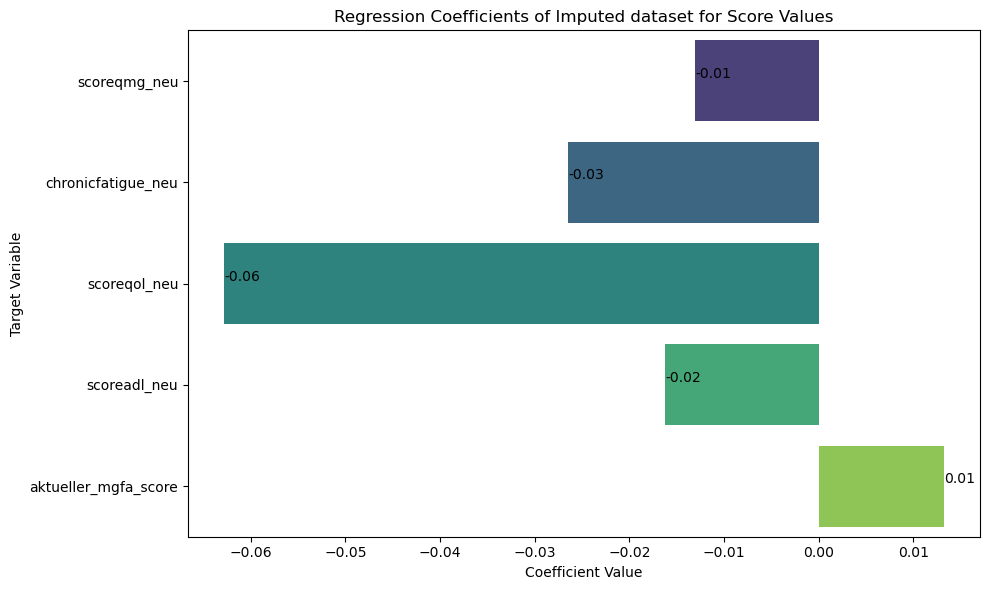

In [20]:
# Plotting the coefficients as a horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Target', data=coefficients_df, orient='h', palette='viridis')

# Add labels and title
plt.title('Regression Coefficients of Imputed dataset for Score Values')
plt.xlabel('Coefficient Value')
plt.ylabel('Target Variable')

# Add numerical values on the bars
for index, value in enumerate(coefficients_df['Coefficient']):
    plt.text(value, index, f'{value:.2f}', va='bottom', color='black')

# Display the plot
plt.tight_layout()
plt.show()

# Coefficients for both Original & Imputed Dataset

In [21]:
# Define the feature and targets
features = ['facilityid', 'age', 'sex', 'time_erst_to_diag', 'mgfaklassifikation_schlimmste_historisch', 
            'dekrement_testergebnis', 'ee_autoimmunerkrankungen_rbzu', 'ee_thymektomie_gr', 
            'kortison_aktuell', 'azathioprin_aktuell', 'mycophenolatmofetil_aktuell', 
            'methotrexatfolsauure_aktuell', 'rituximab_aktuell', 'seronegative']

# List of targets (outcome variables)
targets = ['scoreqmg_neu', 'chronicfatigue_neu', 'scoreqol_neu', 'scoreadl_neu', 'aktueller_mgfa_score']

In [22]:
# Coefficients for Original Dataset
X = df_cleaned[features]  # Features

# Initialize an empty DataFrame to store coefficients
coefficients_df = pd.DataFrame()

# Loop over each target and fit a Linear Regression model
for target in targets:
    y = df_cleaned[target]  # Target variable
    model = LinearRegression()
    model.fit(X, y)
    
    # Create a DataFrame to store the coefficients for this target
    target_coefficients = pd.DataFrame(model.coef_, index=features, columns=[f'coefficient_{target}']).round(4)
    
    # Append the coefficients to the main DataFrame
    coefficients_df = pd.concat([coefficients_df, target_coefficients], axis=1)

# Output the final table of coefficients
coefficients_df

,coefficient_scoreqmg_neu,coefficient_chronicfatigue_neu,coefficient_scoreqol_neu,coefficient_scoreadl_neu,coefficient_aktueller_mgfa_score
facilityid,0.0628,-0.0434,0.0206,0.0226,0.0242
age,0.0022,-0.1031,-0.0619,-0.0058,0.0031
sex,-2.2670,-2.4000,-8.9655,-2.3493,-0.3204
time_erst_to_diag,-0.0827,0.0436,0.2041,-0.0163,0.0231
mgfaklassifikation_schlimmste_historisch,1.3773,0.9523,2.9861,0.7972,0.5977
dekrement_testergebnis,0.6865,-1.7415,1.4040,-0.3547,0.2208
ee_autoimmunerkrankungen_rbzu,-0.5896,-0.7670,-7.1064,-1.6060,-0.3018
ee_thymektomie_gr,-1.1645,-2.0278,-1.5337,0.1011,-0.1992
kortison_aktuell,2.3757,0.8172,6.7613,1.7515,0.2578
azathioprin_aktuell,1.9303,1.2439,1.8678,0.9337,0.2397


In [23]:
# Coefficients for Imputed Dataset
X = df_imputed_dataset[features]  # Features

# Initialize an empty DataFrame to store coefficients
coefficients_df = pd.DataFrame()

# Loop over each target and fit a Linear Regression model
for target in targets:
    y = df_imputed_dataset[target]  # Target variable
    model = LinearRegression()
    model.fit(X, y)
    
    # Create a DataFrame to store the coefficients for this target
    target_coefficients = pd.DataFrame(model.coef_, index=features, columns=[f'coefficient_{target}']).round(4)
    
    # Append the coefficients to the main DataFrame
    coefficients_df = pd.concat([coefficients_df, target_coefficients], axis=1)

# Output the final table of coefficients
coefficients_df

,coefficient_scoreqmg_neu,coefficient_chronicfatigue_neu,coefficient_scoreqol_neu,coefficient_scoreadl_neu,coefficient_aktueller_mgfa_score
facilityid,-0.0130,-0.0264,-0.0628,-0.0162,0.0132
age,0.0006,0.0044,0.0172,0.0026,-0.0042
sex,-1.1806,-1.3551,-3.4140,-0.9380,-0.1851
time_erst_to_diag,0.0352,0.0873,0.1912,0.0727,0.0064
mgfaklassifikation_schlimmste_historisch,1.0528,0.7989,2.9461,0.7423,0.6156
dekrement_testergebnis,-0.2491,-0.5918,-0.4941,-0.4008,-0.0940
ee_autoimmunerkrankungen_rbzu,-0.0910,-0.0066,-0.2663,-0.1822,-0.0562
ee_thymektomie_gr,-0.1715,-0.3431,-1.4033,-0.2325,-0.1820
kortison_aktuell,1.6000,1.4522,4.2186,1.2223,0.3742
azathioprin_aktuell,0.3131,0.4680,0.0098,-0.0021,0.0866


# Confidence Intervals for both Original & Imputed Dataset

In [24]:
# Confidence Intervals for Original Dataset
# Initialize an empty DataFrame to store confidence intervals
ols_confidence_intervals_df = pd.DataFrame()

# Loop over each target and fit an OLS model
for target in targets:
    y = df_cleaned[target]  # Target variable
    
    # Add a constant term to the model (intercept)
    X_with_const = sm.add_constant(X)
    
    # Align indices between X and y by dropping rows where either is missing
    X_with_const, y_aligned = X_with_const.align(y, join='inner', axis=0)
    
    # Fit OLS model
    ols_model = sm.OLS(y_aligned, X_with_const).fit()
    
    # Get the confidence intervals
    confidence_intervals = ols_model.conf_int()
    
    # Rename the columns for clarity
    confidence_intervals.columns = [f'Lower_CI_{target}', f'Upper_CI_{target}']
    
    # Append the confidence intervals to the main DataFrame
    ols_confidence_intervals_df = pd.concat([ols_confidence_intervals_df, confidence_intervals], axis=1)

# Round the confidence intervals to 4 decimal places
ols_confidence_intervals_df = ols_confidence_intervals_df.round(4)

# Output the final table of OLS confidence intervals
ols_confidence_intervals_df


,Lower_CI_scoreqmg_neu,Upper_CI_scoreqmg_neu,Lower_CI_chronicfatigue_neu,Upper_CI_chronicfatigue_neu,Lower_CI_scoreqol_neu,Upper_CI_scoreqol_neu,Lower_CI_scoreadl_neu,Upper_CI_scoreadl_neu,Lower_CI_aktueller_mgfa_score,Upper_CI_aktueller_mgfa_score
const,-496303.1575,242902.1046,-402104.6169,577280.1743,-1.052113e+06,968842.2214,-308800.8041,217634.4115,-130723.6951,33061.8256
facilityid,-0.1203,0.2458,-0.2859,0.1992,-4.799000e-01,0.5211,-0.1078,0.1529,-0.0164,0.0647
age,-0.0602,0.0647,-0.1858,-0.0203,-2.327000e-01,0.1089,-0.0503,0.0387,-0.0107,0.0170
sex,-4.2053,-0.3287,-4.9681,0.1681,-1.426470e+01,-3.6663,-3.7296,-0.9689,-0.7498,0.1091
time_erst_to_diag,-0.3299,0.1645,-0.2839,0.3712,-4.718000e-01,0.8799,-0.1924,0.1597,-0.0317,0.0779
mgfaklassifikation_schlimmste_historisch,0.8071,1.9475,0.1968,1.7077,1.427200e+00,4.5449,0.3911,1.2033,0.4713,0.7240
dekrement_testergebnis,-1.2354,2.6083,-4.2878,0.8048,-3.850300e+00,6.6582,-1.7234,1.0140,-0.2050,0.6467
ee_autoimmunerkrankungen_rbzu,-2.7623,1.5831,-3.6456,2.1116,-1.304640e+01,-1.1664,-3.1534,-0.0587,-0.7832,0.1796
ee_thymektomie_gr,-3.4643,1.1352,-5.0747,1.0192,-7.821100e+00,4.7538,-1.5367,1.7389,-0.7088,0.3103
kortison_aktuell,0.5339,4.2175,-1.6230,3.2575,1.725900e+00,11.7967,0.4399,3.0632,-0.1503,0.6658


In [25]:
# Confidence Intervals for Imputed Dataset
# Initialize an empty DataFrame to store confidence intervals
ols_confidence_intervals_df = pd.DataFrame()

# Loop over each target and fit an OLS model
for target in targets:
    y = df_imputed_dataset[target]  # Target variable
    
    # Add a constant term to the model (intercept)
    X_with_const = sm.add_constant(X)
    
    # Align indices between X and y by dropping rows where either is missing
    X_with_const, y_aligned = X_with_const.align(y, join='inner', axis=0)
    
    # Fit OLS model
    ols_model = sm.OLS(y_aligned, X_with_const).fit()
    
    # Get the confidence intervals
    confidence_intervals = ols_model.conf_int()
    
    # Rename the columns for clarity
    confidence_intervals.columns = [f'Lower_CI_{target}', f'Upper_CI_{target}']
    
    # Append the confidence intervals to the main DataFrame
    ols_confidence_intervals_df = pd.concat([ols_confidence_intervals_df, confidence_intervals], axis=1)

# Round the confidence intervals to 4 decimal places
ols_confidence_intervals_df = ols_confidence_intervals_df.round(4)

# Output the final table of OLS confidence intervals
ols_confidence_intervals_df

,Lower_CI_scoreqmg_neu,Upper_CI_scoreqmg_neu,Lower_CI_chronicfatigue_neu,Upper_CI_chronicfatigue_neu,Lower_CI_scoreqol_neu,Upper_CI_scoreqol_neu,Lower_CI_scoreadl_neu,Upper_CI_scoreadl_neu,Lower_CI_aktueller_mgfa_score,Upper_CI_aktueller_mgfa_score
const,-45426.6727,98095.9876,-48840.8031,155654.6612,-76773.1792,330482.8353,-18166.0675,83720.9938,-45662.4041,-7765.4255
facilityid,-0.0486,0.0225,-0.0771,0.0242,-0.1637,0.0380,-0.0415,0.0090,0.0038,0.0226
age,-0.0108,0.0120,-0.0118,0.0206,-0.0151,0.0494,-0.0054,0.0107,-0.0072,-0.0012
sex,-1.5757,-0.7856,-1.9180,-0.7923,-4.5350,-2.2930,-1.2184,-0.6575,-0.2894,-0.0808
time_erst_to_diag,-0.0135,0.0839,0.0179,0.1566,0.0530,0.3293,0.0381,0.1072,-0.0064,0.0193
mgfaklassifikation_schlimmste_historisch,0.9424,1.1632,0.6417,0.9562,2.6329,3.2594,0.6639,0.8207,0.5865,0.6448
dekrement_testergebnis,-0.6201,0.1220,-1.1206,-0.0631,-1.5471,0.5589,-0.6642,-0.1374,-0.1919,0.0040
ee_autoimmunerkrankungen_rbzu,-0.5165,0.3346,-0.6129,0.5998,-1.4738,0.9412,-0.4843,0.1199,-0.1685,0.0562
ee_thymektomie_gr,-0.5904,0.2473,-0.9399,0.2537,-2.5918,-0.2147,-0.5299,0.0648,-0.2926,-0.0714
kortison_aktuell,1.2373,1.9627,0.9354,1.9690,3.1894,5.2478,0.9648,1.4798,0.2785,0.4700


# scoreqmg_neu_dataset

In [26]:
columns_scoreqmg_neu= ['facilityid', 'age', 'sex', 'time_erst_to_diag', 'mgfaklassifikation_schlimmste_historisch', 'dekrement_testergebnis', 'ee_autoimmunerkrankungen_rbzu', 
                       'ee_thymektomie_gr', 'kortison_aktuell', 'azathioprin_aktuell', 'mycophenolatmofetil_aktuell', 'methotrexatfolsauure_aktuell','rituximab_aktuell', 'scoreqmg_neu', 'seronegative']

df_scoreqmg_neu= df_original[columns_scoreqmg_neu]
df_scoreqmg= df_scoreqmg_neu.dropna()
df_scoreqmg.isnull().sum()

facilityid                                  0
age                                         0
sex                                         0
time_erst_to_diag                           0
mgfaklassifikation_schlimmste_historisch    0
dekrement_testergebnis                      0
ee_autoimmunerkrankungen_rbzu               0
ee_thymektomie_gr                           0
kortison_aktuell                            0
azathioprin_aktuell                         0
mycophenolatmofetil_aktuell                 0
methotrexatfolsauure_aktuell                0
rituximab_aktuell                           0
scoreqmg_neu                                0
seronegative                                0
dtype: int64

# chronicfatigue_neu_dataset

In [27]:
columns_chronicfatigue_neu= ['facilityid', 'age', 'sex', 'time_erst_to_diag', 'mgfaklassifikation_schlimmste_historisch', 'dekrement_testergebnis', 'ee_autoimmunerkrankungen_rbzu', 
                            'ee_thymektomie_gr', 'kortison_aktuell', 'azathioprin_aktuell', 'mycophenolatmofetil_aktuell', 'methotrexatfolsauure_aktuell','rituximab_aktuell', 'chronicfatigue_neu', 'seronegative']

df_chronicfatigue_neu= df_original[columns_chronicfatigue_neu]
df_chronicfatigue= df_chronicfatigue_neu.dropna()
df_chronicfatigue.isnull().sum()

facilityid                                  0
age                                         0
sex                                         0
time_erst_to_diag                           0
mgfaklassifikation_schlimmste_historisch    0
dekrement_testergebnis                      0
ee_autoimmunerkrankungen_rbzu               0
ee_thymektomie_gr                           0
kortison_aktuell                            0
azathioprin_aktuell                         0
mycophenolatmofetil_aktuell                 0
methotrexatfolsauure_aktuell                0
rituximab_aktuell                           0
chronicfatigue_neu                          0
seronegative                                0
dtype: int64

# scoreqol_neu_dataset

In [28]:
columns_scoreqol_neu= ['facilityid', 'age', 'sex', 'time_erst_to_diag', 'mgfaklassifikation_schlimmste_historisch', 'dekrement_testergebnis', 'ee_autoimmunerkrankungen_rbzu', 
                     'ee_thymektomie_gr', 'kortison_aktuell', 'azathioprin_aktuell', 'mycophenolatmofetil_aktuell', 'methotrexatfolsauure_aktuell','rituximab_aktuell', 'scoreqol_neu', 'seronegative']

df_scoreqol_neu= df_original[columns_scoreqol_neu]
df_scoreqol= df_scoreqol_neu.dropna()
df_scoreqol.isnull().sum()

facilityid                                  0
age                                         0
sex                                         0
time_erst_to_diag                           0
mgfaklassifikation_schlimmste_historisch    0
dekrement_testergebnis                      0
ee_autoimmunerkrankungen_rbzu               0
ee_thymektomie_gr                           0
kortison_aktuell                            0
azathioprin_aktuell                         0
mycophenolatmofetil_aktuell                 0
methotrexatfolsauure_aktuell                0
rituximab_aktuell                           0
scoreqol_neu                                0
seronegative                                0
dtype: int64

# scoreadl_neu_dataset

In [29]:
columns_scoreadl_neu= ['facilityid', 'age', 'sex', 'time_erst_to_diag', 'mgfaklassifikation_schlimmste_historisch', 'dekrement_testergebnis', 'ee_autoimmunerkrankungen_rbzu', 
                     'ee_thymektomie_gr', 'kortison_aktuell', 'azathioprin_aktuell', 'mycophenolatmofetil_aktuell', 'methotrexatfolsauure_aktuell','rituximab_aktuell', 'scoreadl_neu', 'seronegative']

df_scoreadl_neu= df_original[columns_scoreadl_neu]
df_scoreadl= df_scoreadl_neu.dropna()
df_scoreadl.isnull().sum()

facilityid                                  0
age                                         0
sex                                         0
time_erst_to_diag                           0
mgfaklassifikation_schlimmste_historisch    0
dekrement_testergebnis                      0
ee_autoimmunerkrankungen_rbzu               0
ee_thymektomie_gr                           0
kortison_aktuell                            0
azathioprin_aktuell                         0
mycophenolatmofetil_aktuell                 0
methotrexatfolsauure_aktuell                0
rituximab_aktuell                           0
scoreadl_neu                                0
seronegative                                0
dtype: int64

# aktueller_mgfa_score_dataset

In [30]:
columns_aktueller_mgfa_score= ['facilityid', 'age', 'sex', 'time_erst_to_diag', 'mgfaklassifikation_schlimmste_historisch', 'dekrement_testergebnis', 'ee_autoimmunerkrankungen_rbzu', 
                     'ee_thymektomie_gr', 'kortison_aktuell', 'azathioprin_aktuell', 'mycophenolatmofetil_aktuell', 'methotrexatfolsauure_aktuell','rituximab_aktuell', 'aktueller_mgfa_score', 'seronegative']

df_aktueller_mgfa_score= df_original[columns_aktueller_mgfa_score]
df_aktueller_mgfa= df_aktueller_mgfa_score.dropna()
df_aktueller_mgfa.isnull().sum()

facilityid                                  0
age                                         0
sex                                         0
time_erst_to_diag                           0
mgfaklassifikation_schlimmste_historisch    0
dekrement_testergebnis                      0
ee_autoimmunerkrankungen_rbzu               0
ee_thymektomie_gr                           0
kortison_aktuell                            0
azathioprin_aktuell                         0
mycophenolatmofetil_aktuell                 0
methotrexatfolsauure_aktuell                0
rituximab_aktuell                           0
aktueller_mgfa_score                        0
seronegative                                0
dtype: int64

# Forest Plot for Original & Imputed Dataset for Seronegative

In [31]:
# Function to perform regression and return the coefficient and confidence interval for seronegative
def get_seronegative_results(df, features, target):
    X = df[features]
    y = df[target]
    
    # Add constant for intercept
    X = sm.add_constant(X)
    
    # Fit the OLS model
    model = sm.OLS(y, X).fit()
    
    # Get the coefficient and confidence interval for 'seronegative'
    seronegative_coef = round(model.params['seronegative'], 2)
    seronegative_conf = model.conf_int().loc['seronegative'].round(2)  
    
    return seronegative_coef, seronegative_conf

# Function to plot the forest plot with regression coefficients and 95% CI in an extra column
def plot_forest_plot_with_coef_ci(coefs, confs, targets, datasets, title, show_row_count=False):
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size

    # Add labels and ticks with the number of rows for each dataset (only for original dataset if show_row_count is True)
    if show_row_count:
        targets_with_row_count = [f'{target} (n={datasets[target].shape[0]})' for target in targets]
    else:
        targets_with_row_count = targets

    # Plot the regression coefficients and confidence intervals
    for i, (coef, (lower, upper)) in enumerate(zip(coefs, confs)):
        ax.errorbar(coef, i, xerr=[[coef - lower], [upper - coef]], fmt='s', color='black', ecolor='gray', elinewidth=2, capsize=3)

    # Add vertical line at 0
    ax.axvline(x=0, linestyle='--', color='black', linewidth=1)

    # Add the targets with row counts or not based on the `show_row_count` flag
    ax.set_yticks(range(len(coefs)))  
    ax.set_yticklabels(targets_with_row_count)  
    ax.set_xlim([-1, 7])  

    ax.set_xlabel('Coefficient')
    ax.set_title(title)
    

    # Add the regression coefficient and 95% CI numbers in an extra column (outside the plot)
    for i, (coef, (lower, upper)) in enumerate(zip(coefs, confs)):
        ax.text(7.2, i, f'{coef:.2f}', va='center', ha='left', fontsize=10)  
        ax.text(8.5, i, f'[{lower:.2f}, {upper:.2f}]', va='center', ha='left', fontsize=10, color='green')  

    # Add titles for "Coefficient" and "95% CI" at the top, properly spaced to avoid overlapping
        ax.text(7.2, len(coefs) + 0.5, 'Coefficient', va='center', ha='left', fontsize=12, fontweight='bold') 
        ax.text(9.0, len(coefs) + 0.5, '95% CI', va='center', ha='left', fontsize=12, fontweight='bold')  

    plt.tight_layout()
    plt.show()

# Features
features = ['facilityid', 'age', 'sex', 'time_erst_to_diag', 'mgfaklassifikation_schlimmste_historisch', 
            'dekrement_testergebnis', 'ee_autoimmunerkrankungen_rbzu', 'ee_thymektomie_gr', 
            'kortison_aktuell', 'azathioprin_aktuell', 'mycophenolatmofetil_aktuell', 
            'methotrexatfolsauure_aktuell', 'rituximab_aktuell', 'seronegative']

# Target datasets (original and imputed)
original_datasets = {
    'scoreqmg_neu': df_scoreqmg,
    'chronicfatigue_neu': df_chronicfatigue,
    'scoreqol_neu': df_scoreqol,
    'scoreadl_neu': df_scoreadl,
    'aktueller_mgfa_score': df_aktueller_mgfa
}

# Imputed dataset
df_imputed_dataset = df_imputed_dataset

# Lists to store coefficients and confidence intervals for imputed datasets
coefs_imputed = []
confs_imputed = []

# Lists to store coefficients and confidence intervals for original datasets
coefs_original = []
confs_original = []

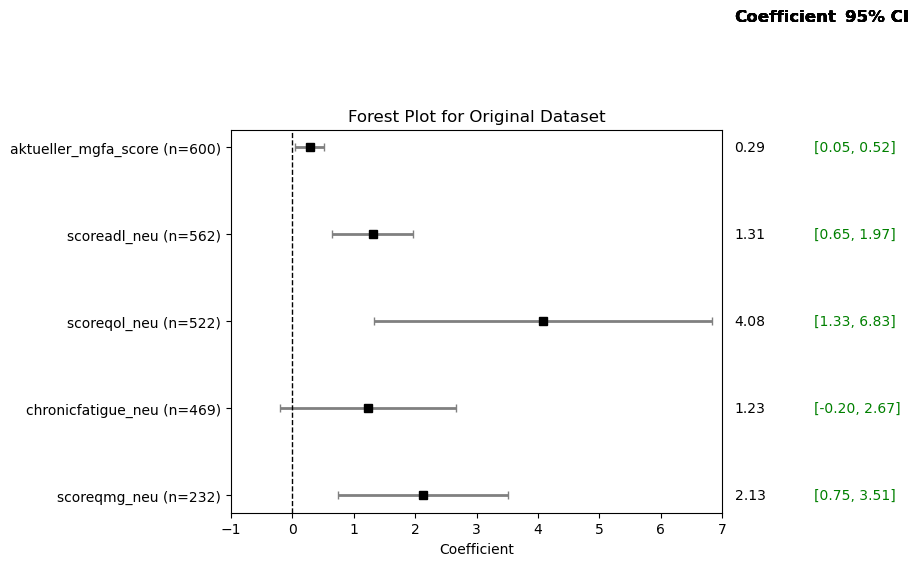

In [32]:
# Get results for each target in the original dataset
for target, df in original_datasets.items():
    coef, conf = get_seronegative_results(df, features, target)
    coefs_original.append(coef)
    confs_original.append(conf)

# Convert to NumPy arrays for easier manipulation
confs_original = np.array(confs_original)

# Plot for the original dataset WITH row counts and regression coefficient, 95% CI in an extra column
plot_forest_plot_with_coef_ci(coefs_original, confs_original, list(original_datasets.keys()), original_datasets, 'Forest Plot for Original Dataset', show_row_count=True)

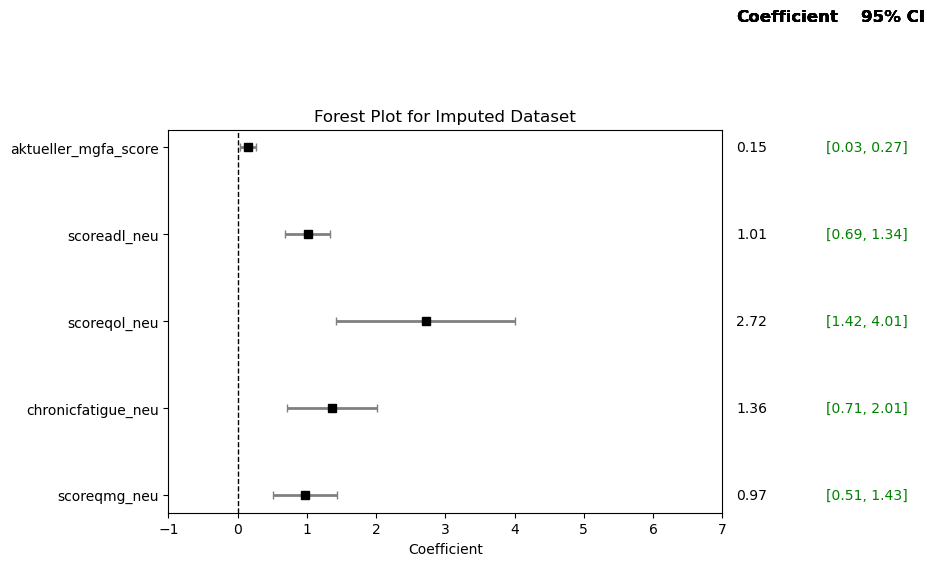

In [33]:
# Get results for each target in the imputed dataset
for target in original_datasets.keys():
    coef, conf = get_seronegative_results(df_imputed_dataset, features, target)
    coefs_imputed.append(coef)
    confs_imputed.append(conf)

# Convert to NumPy arrays for easier manipulation
confs_imputed = np.array(confs_imputed)

# Plot for the imputed dataset WITHOUT row counts (but displaying regression coefficient and 95% CI)
plot_forest_plot_with_coef_ci(coefs_imputed, confs_imputed, list(original_datasets.keys()), original_datasets, 'Forest Plot for Imputed Dataset', show_row_count=False)

# Forest Plot for Original & Imputed Dataset for Gender

In [34]:
# Function to perform regression and return the coefficient and confidence interval for 'sex'
def get_sex_results(df, features, target):
    X = df[features]
    y = df[target]
    
    # Add constant for intercept
    X = sm.add_constant(X)
    
    # Fit the OLS model
    model = sm.OLS(y, X).fit()
    
    # Get the coefficient and confidence interval for 'sex'
    sex_coef = round(model.params['sex'], 2)
    sex_conf = model.conf_int().loc['sex'].round(2)  
    
    return sex_coef, sex_conf

# Function to plot the forest plot with regression coefficients and 95% CI in an extra column
def plot_forest_plot_with_coef_ci(coefs, confs, targets, datasets, title, show_row_count=False):
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size

    # Add labels and ticks with the number of rows for each dataset (only for original dataset if show_row_count is True)
    if show_row_count:
        # Display 'n=<row count>' for each target instead of 'rows'
        targets_with_row_count = [f'{target} (n={datasets[target].shape[0]})' for target in targets]
    else:
        targets_with_row_count = targets

    # Plot the regression coefficients and confidence intervals
    for i, (coef, (lower, upper)) in enumerate(zip(coefs, confs)):
        # Plot the effect size point (square) and confidence interval (line)
        ax.errorbar(coef, i, xerr=[[coef - lower], [upper - coef]], fmt='s', color='black', ecolor='gray', elinewidth=2, capsize=3)

    # Add vertical line at 0
    ax.axvline(x=0, linestyle='--', color='black', linewidth=1)

    # Add the targets with row counts or not based on the `show_row_count` flag
    ax.set_yticks(range(len(coefs)))  # No "Overall Effect"
    ax.set_yticklabels(targets_with_row_count)  # Use row counts in target names if specified
    ax.set_xlim([-7, 1])  # Adjust x-axis limit for better spacing

    ax.set_xlabel('Coefficient')
    ax.set_title(title)
    

    # Add the regression coefficient and 95% CI numbers in an extra column (outside the plot)
    for i, (coef, (lower, upper)) in enumerate(zip(coefs, confs)):
        ax.text(7.2, i, f'{coef:.2f}', va='center', ha='left', fontsize=10)  # Shift Coefficient further to the left
        ax.text(8.5, i, f'[{lower:.2f}, {upper:.2f}]', va='center', ha='left', fontsize=10, color='green')  # Shift 95% CI further to the left

    # Add titles for "Coefficient" and "95% CI" at the top, properly spaced to avoid overlapping
        ax.text(7.2, len(coefs) + 0.5, 'Coefficient', va='center', ha='left', fontsize=12, fontweight='bold')  # Adjust Coefficient title
        ax.text(9.0, len(coefs) + 0.5, '95% CI', va='center', ha='left', fontsize=12, fontweight='bold')  # Adjust 95% CI title further to the right

    plt.tight_layout()
    plt.show()

# Features
features = ['facilityid', 'age', 'sex', 'time_erst_to_diag', 'mgfaklassifikation_schlimmste_historisch', 
            'dekrement_testergebnis', 'ee_autoimmunerkrankungen_rbzu', 'ee_thymektomie_gr', 
            'kortison_aktuell', 'azathioprin_aktuell', 'mycophenolatmofetil_aktuell', 
            'methotrexatfolsauure_aktuell', 'rituximab_aktuell', 'seronegative']

# Target datasets (original and imputed)
original_datasets = {
    'scoreqmg_neu': df_scoreqmg,
    'chronicfatigue_neu': df_chronicfatigue,
    'scoreqol_neu': df_scoreqol,
    'scoreadl_neu': df_scoreadl,
    'aktueller_mgfa_score': df_aktueller_mgfa
}

# Imputed dataset
df_imputed_dataset = df_imputed_dataset

# Lists to store coefficients and confidence intervals for imputed datasets
coefs_imputed = []
confs_imputed = []

# Lists to store coefficients and confidence intervals for original datasets
coefs_original = []
confs_original = []

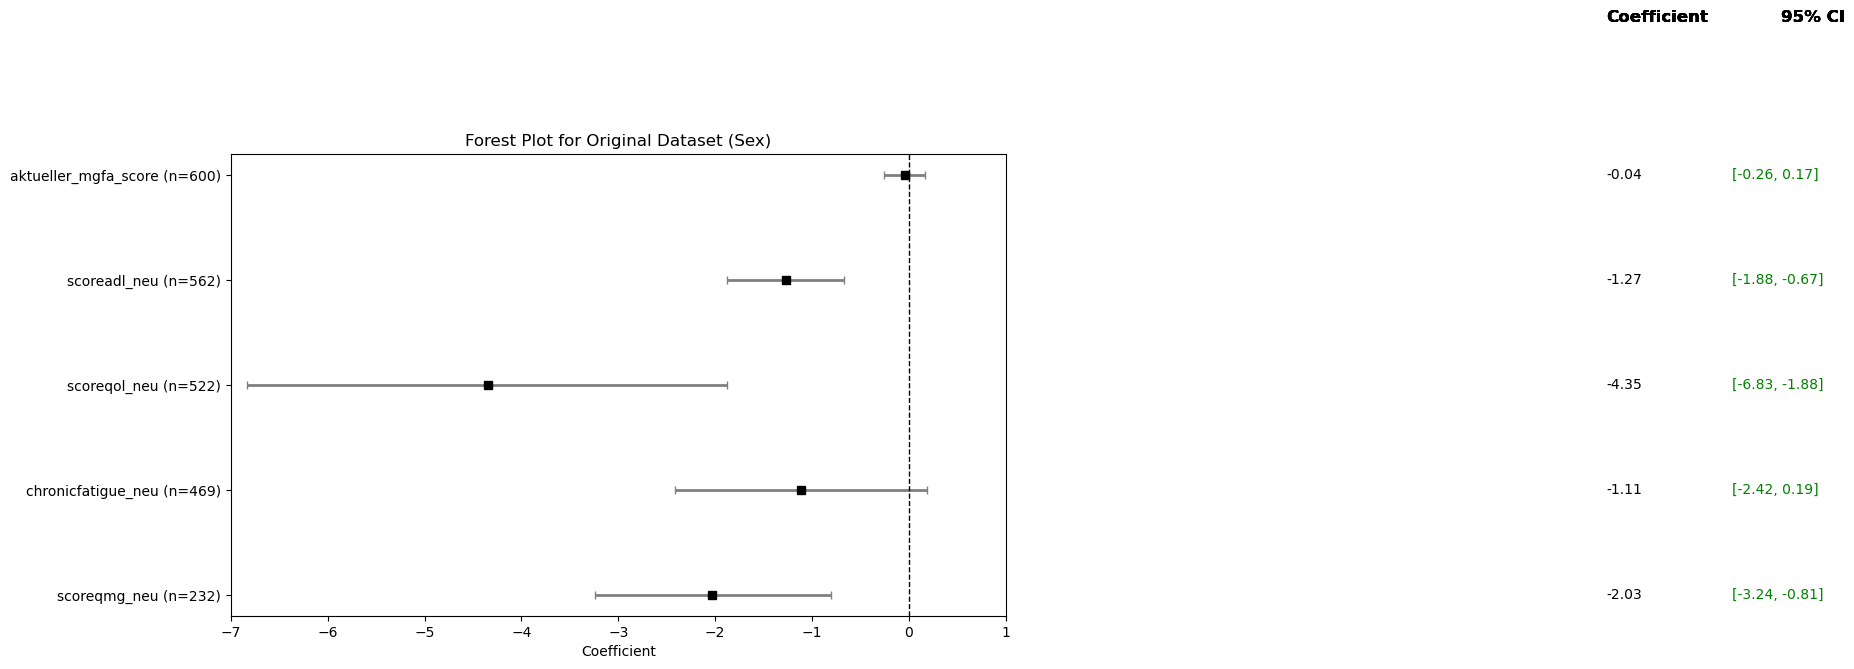

In [35]:
# Get results for each target in the original dataset
for target, df in original_datasets.items():
    coef, conf = get_sex_results(df, features, target)
    coefs_original.append(coef)
    confs_original.append(conf)

# Convert to NumPy arrays for easier manipulation
confs_original = np.array(confs_original)

# Plot for the original dataset WITH row counts and regression coefficient, 95% CI in an extra column
plot_forest_plot_with_coef_ci(coefs_original, confs_original, list(original_datasets.keys()), original_datasets, 'Forest Plot for Original Dataset (Sex)', show_row_count=True)

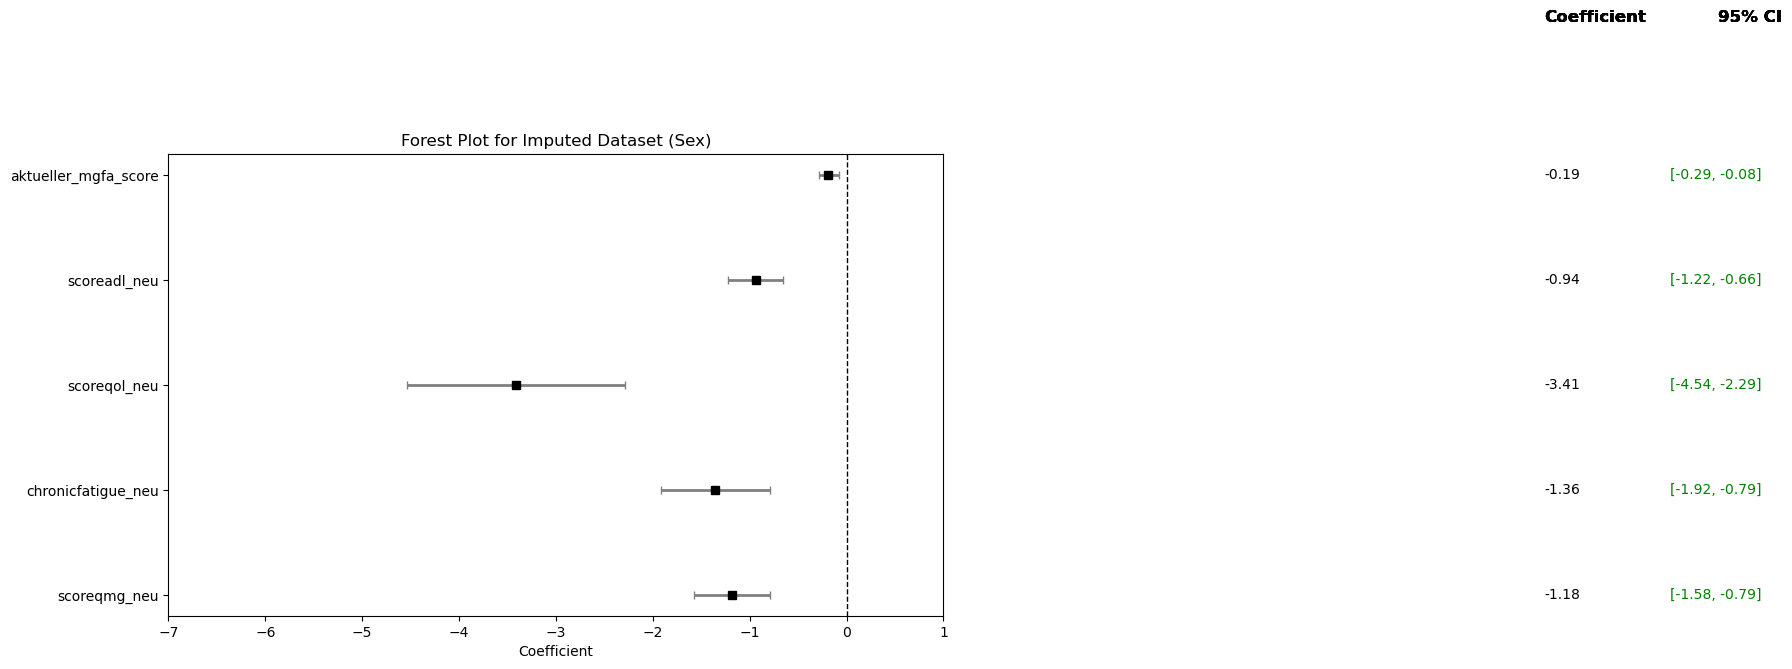

In [36]:
# Get results for each target in the imputed dataset
for target in original_datasets.keys():
    coef, conf = get_sex_results(df_imputed_dataset, features, target)
    coefs_imputed.append(coef)
    confs_imputed.append(conf)

# Convert to NumPy arrays for easier manipulation
confs_imputed = np.array(confs_imputed)

# Plot for the imputed dataset WITHOUT row counts (but displaying regression coefficient and 95% CI)
plot_forest_plot_with_coef_ci(coefs_imputed, confs_imputed, list(original_datasets.keys()), original_datasets, 'Forest Plot for Imputed Dataset (Sex)', show_row_count=False)